In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

NUM_INFERENCES = 7

In [2]:
# download mnist fashion data set
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# set clas names
CLASS_NAMES = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# derive number training examples and number of classes
NUM_TRAIN_EXAMPLES = len(train_images)
NUM_CLASSES = len(CLASS_NAMES)

4431872/4422102 [==============================] - 0s 0us/step


Train point-estimate model

In [3]:
def build_and_compile_point_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), padding='same',
                             activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPool2D(strides=2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(NUM_CLASSES)
  ])
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [4]:
print("Train point model")
model = build_and_compile_point_model()
model.fit(train_images, train_labels, epochs=10) 

Train point model
Epoch 1/2
1875/1875 [==============================] - 55s 29ms/step - loss: 0.7798 - accuracy: 0.8544
Epoch 2/2
1875/1875 [==============================] - 52s 28ms/step - loss: 0.3252 - accuracy: 0.8854


Train Bayesian model with Reparameterization trick

In [5]:
def define_bayesian_model():

  kl_divergence_function = (lambda q, p, _: tfp.distributions.kl_divergence(q, p) / tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

  model = tf.keras.models.Sequential([
      tfp.layers.Convolution2DReparameterization(
          64, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(
          pool_size=[2, 2], strides=[2, 2],
          padding='SAME'),
      tf.keras.layers.Flatten(),
      tfp.layers.DenseReparameterization(
          NUM_CLASSES, kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.softmax)
  ])
  return model

In [35]:
def compile_bayesian_model(model):
  # Model compilation.
  optimizer = tf.keras.optimizers.Adam()
  # We use the categorical_crossentropy loss since the MNIST dataset contains
  # ten labels. The Keras API will then automatically add the
  # Kullback-Leibler divergence (contained on the individual layers of
  # the model), to the cross entropy loss, effectively
  # calcuating the (negated) Evidence Lower Bound Loss (ELBO)
  model.compile(optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'], experimental_run_tf_function=False)

  model.build(input_shape=[None, 28, 28, 1])
  return model


In [36]:
train_labels_dense = tf.one_hot(train_labels, NUM_CLASSES)
train_labels_dense.shape

TensorShape([60000, 10])

In [37]:
# use helper function to define the model architecture
bayesian_model = define_bayesian_model()
# use helper function to compile the model
bayesian_model = compile_bayesian_model(bayesian_model)
# initiate model training
bayesian_model.fit(train_images, train_labels_dense, epochs=10)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


Epoch 1/10
1875/1875 [==============================] - 91s 48ms/step - loss: 44.8520 - accuracy: 0.7211
Epoch 2/10
1875/1875 [==============================] - 68s 36ms/step - loss: 8.9676 - accuracy: 0.7381
Epoch 3/10
1875/1875 [==============================] - 66s 35ms/step - loss: 6.6551 - accuracy: 0.7325
Epoch 4/10
1875/1875 [==============================] - 66s 35ms/step - loss: 6.0315 - accuracy: 0.7609
Epoch 5/10
1875/1875 [==============================] - 66s 35ms/step - loss: 5.7456 - accuracy: 0.7866
Epoch 6/10
1875/1875 [==============================] - 66s 35ms/step - loss: 5.4154 - accuracy: 0.8028
Epoch 7/10
1875/1875 [==============================] - 65s 35ms/step - loss: 4.8654 - accuracy: 0.8166
Epoch 8/10
1875/1875 [==============================] - 66s 35ms/step - loss: 4.0118 - accuracy: 0.8239
Epoch 9/10
1875/1875 [==============================] - 66s 35ms/step - loss: 2.9274 - accuracy: 0.8260
Epoch 10/10
1875/1875 [==============================] - 66s 35

In [38]:
NUM_SAMPLES_INFERENCE = 50
softmax_predictions = tf.stack(
    [bayesian_model.predict(test_images[:NUM_SAMPLES_INFERENCE])
     for _ in range(NUM_INFERENCES)],axis=0)

In [41]:
# get the class predictions for the first image in the test set
image_ind = 0
# collect class predictions
class_predictions = []
for ind in range(NUM_INFERENCES):
  prediction_this_inference = np.argmax(softmax_predictions[ind][image_ind])
  class_predictions.append(prediction_this_inference)
# get class predictions in human-readable form
predicted_classes = [CLASS_NAMES[ind] for ind in class_predictions]

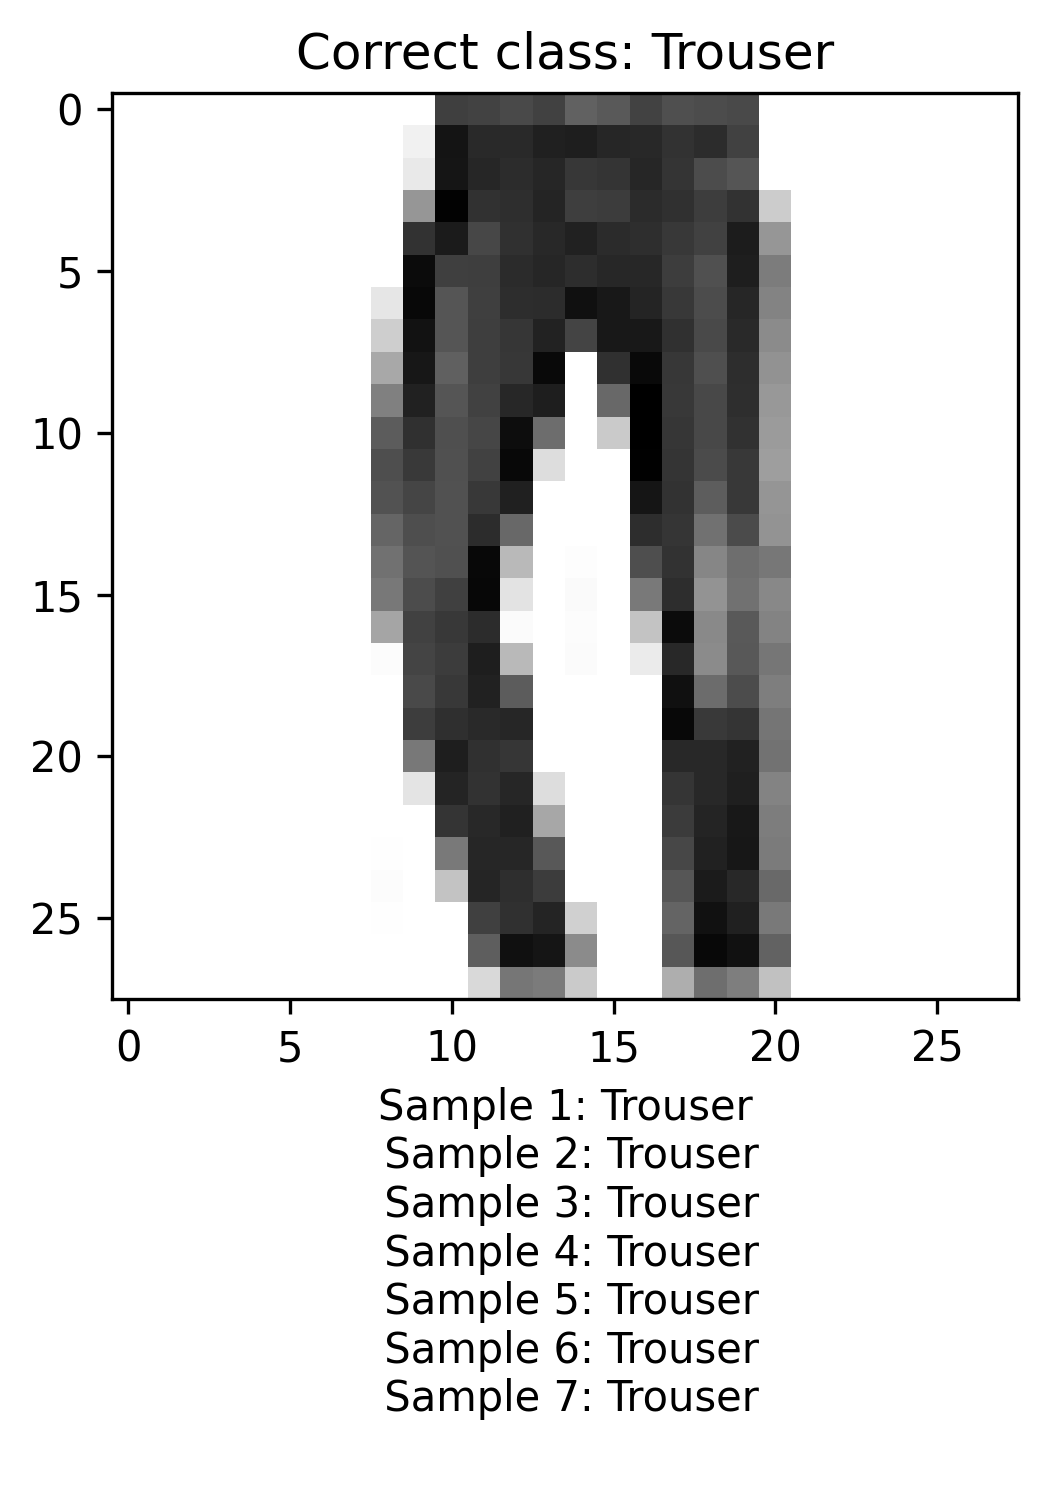

In [42]:
# define image caption
image_caption = []
for caption in range(NUM_INFERENCES):
  image_caption.append(f"Sample {caption+1}: {predicted_classes[caption]}\n")
image_caption = ' '.join(image_caption)
# visualise image and predictions
plt.figure(dpi=300)
plt.title(f"Correct class: {CLASS_NAMES[test_labels[image_ind]]}")
plt.imshow(test_images[image_ind], cmap=plt.cm.binary)
plt.xlabel(image_caption)
plt.show()

In [43]:
# calculate variance across model predictions
var_predictions = tf.reduce_mean(
    tf.math.reduce_variance(softmax_predictions, axis=0),
    axis=1)

In [44]:
# print variance
print(var_predictions[0].numpy())

2.4859935e-07


In [51]:
# load MNIST to get OOD data
(train_images_mnist, train_labels_mnist), (test_images_mnist, test_labels_mnist) = tf.keras.datasets.mnist.load_data()

In [52]:
# get model predictions in MNIST data
softmax_predictions_mnist = tf.stack([bayesian_model.predict(test_images_mnist[:NUM_SAMPLES_INFERENCE])
                                      for _ in range(NUM_INFERENCES)], axis=0)

In [53]:
# calculate variance across model predictions in MNIST data
var_predictions_mnist = tf.reduce_mean(
    tf.math.reduce_variance(softmax_predictions_mnist, axis=0),
    axis=1)

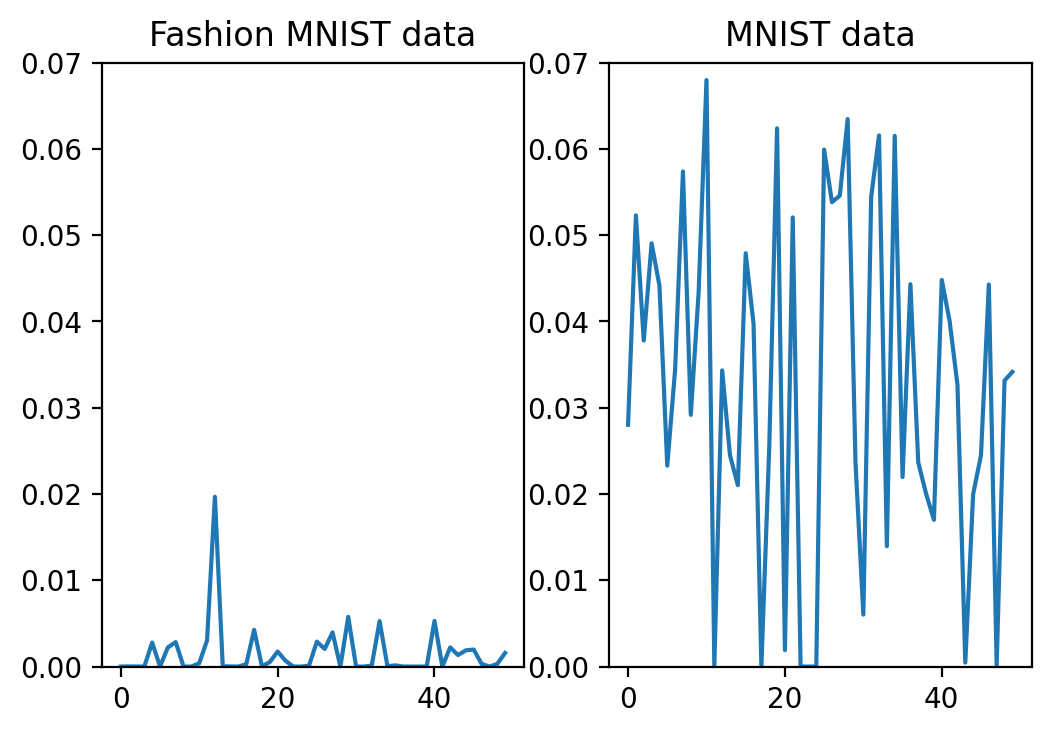

In [54]:
# visualise comparison of MNIST fashion and MNIST variance
fig, ax = plt.subplots(nrows=1, ncols=2, dpi=200)
ax[0].plot(np.arange(NUM_SAMPLES_INFERENCE), var_predictions)
ax[0].set_ylim([0, 0.07])
ax[0].set_title("Fashion MNIST data")
ax[1].plot(np.arange(NUM_SAMPLES_INFERENCE), var_predictions_mnist)
ax[1].set_ylim([0, 0.07])
ax[1].set_title("MNIST data")
plt.show()